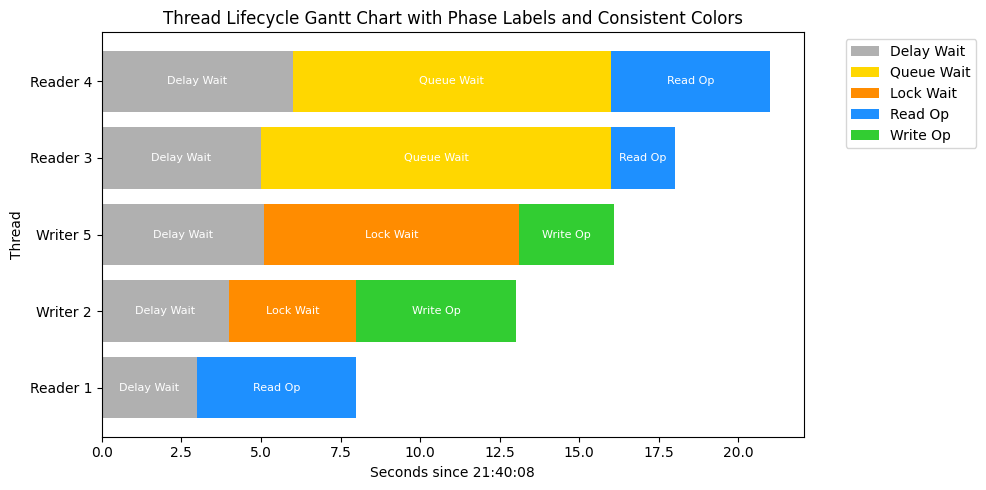

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Define threads and their phases with consistent colors
threads = ['Reader 1', 'Writer 2', 'Writer 5', 'Reader 3', 'Reader 4']
phases = {
    'Reader 1': {
        'Delay Wait': (0, 3),
        'Queue Wait': (3, 0),
        'Lock Wait': (3, 0),
        'Read Op': (3, 5),
    },
    'Writer 2': {
        'Delay Wait': (0, 4),
        'Queue Wait': (4, 0),
        'Lock Wait': (4, 4),
        'Write Op': (8, 5),
    },
    'Writer 5': {
        'Delay Wait': (0, 5.1),
        'Queue Wait': (5.1, 0),
        'Lock Wait': (5.1, 8),
        'Write Op': (13.1, 3),
    },
    'Reader 3': {
        'Delay Wait': (0, 5),
        'Queue Wait': (5, 11),
        'Lock Wait': (16, 0),
        'Read Op': (16, 2),
    },
    'Reader 4': {
        'Delay Wait': (0, 6),
        'Queue Wait': (6, 10),
        'Lock Wait': (16, 0),
        'Read Op': (16, 5),
    },
}

# Define a consistent color map for phases
color_map = {
    'Delay Wait': '#B0B0B0',   # grey
    'Queue Wait': '#FFD700',   # gold
    'Lock Wait': '#FF8C00',    # dark orange
    'Read Op': '#1E90FF',      # dodgerblue
    'Write Op': '#32CD32'      # limegreen
}

fig, ax = plt.subplots(figsize=(10, 5))

# Plot each phase with its designated color
for idx, thread in enumerate(threads):
    for phase, (start, duration) in phases[thread].items():
        if duration > 0:
            ax.barh(thread, duration, left=start, color=color_map[phase])
            ax.text(start + duration/2, idx, phase, va='center', ha='center', fontsize=8, color='white')

# Create custom legend
legend_handles = [Patch(facecolor=color_map[p], label=p) for p in color_map]
ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xlabel('Seconds since 21:40:08')
ax.set_ylabel('Thread')
ax.set_title('Thread Lifecycle Gantt Chart with Phase Labels and Consistent Colors')
plt.tight_layout()
plt.show()

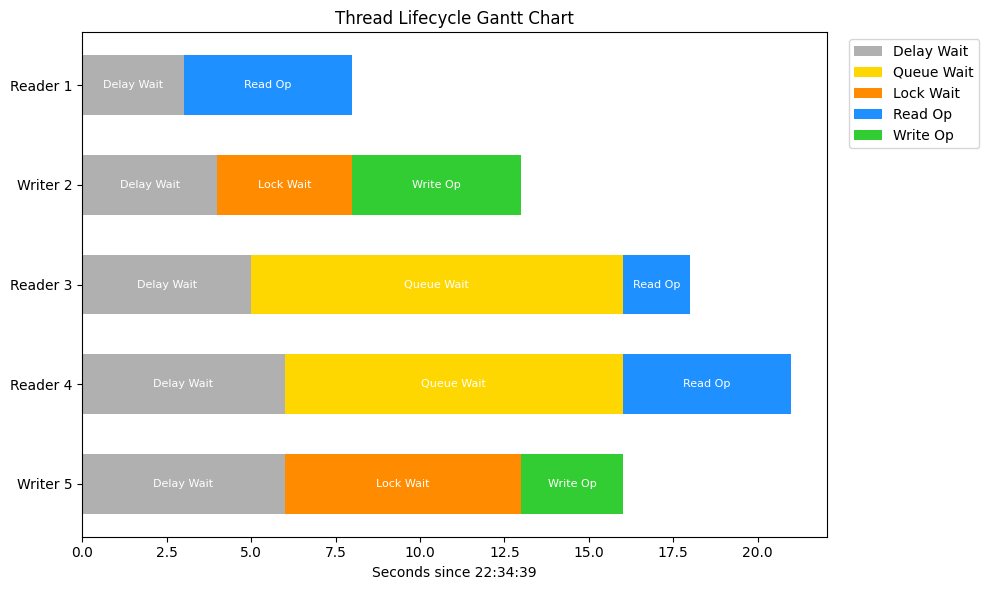

In [5]:
import re
import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 1. 读日志并解析
log_file = 'log.txt'
pattern = re.compile(r'\[(\d{2}:\d{2}:\d{2})\] (Reader|Writer) (\d+): (.+)')
events = {}

with open(log_file) as f:
    lines = f.readlines()

# 取第一个时间戳作为基准 t0
for line in lines:
    m = pattern.match(line)
    if m:
        t0 = datetime.datetime.strptime(m.group(1), '%H:%M:%S')
        break

# 按行提取事件时间点
for line in lines:
    m = pattern.match(line)
    if not m:
        continue
    time_str, role, tid, msg = m.groups()
    t = datetime.datetime.strptime(time_str, '%H:%M:%S')
    offset = (t - t0).total_seconds()
    key = f"{role} {tid}"
    ev = events.setdefault(key, {})

    if msg.startswith('Trying to enter queue'):
        ev['t_try_queue'] = offset
    elif msg.startswith('Entered queue'):
        ev['t_enter_queue'] = offset
    elif msg.startswith('Trying to acquire fmutex'):
        ev['t_try_lock'] = offset
    elif msg.startswith('Acquired fmutex'):
        ev['t_acquired_lock'] = offset
    elif msg.startswith('STARTED'):
        dur = float(msg.split('(')[1].split()[2])
        ev['t_start_op'] = offset
        ev['op_duration'] = dur
    elif msg.startswith('FINISHED'):
        ev['t_end_op'] = offset

# 2. 构造各阶段 start/duration
phases = {}
first_times = {}  # 用于排序
for key, ev in events.items():
    # 找到线程的第一个真正动作时刻：try_queue / try_lock / start_op
    first = min(ev.get('t_try_queue', float('inf')),
                ev.get('t_try_lock', float('inf')),
                ev.get('t_start_op', float('inf')))
    first_times[key] = first

    # Delay      : 从 0 到 first
    # Queue wait : try_queue → enter_queue
    # Lock  wait : try_lock  → acq_lock
    # Op         : t_start_op → op_duration
    d_wait   = first
    q_wait   = max(0, ev.get('t_enter_queue', first) - ev.get('t_try_queue', first))
    lock_wait= max(0, ev.get('t_acquired_lock', first) - ev.get('t_try_lock', first))
    op_start = ev['t_start_op']
    op_dur   = ev['op_duration']
    op_name  = 'Read Op' if key.startswith('Reader') else 'Write Op'

    phases[key] = {
        'Delay Wait': (0,             d_wait),
        'Queue Wait': (ev.get('t_try_queue', first),   q_wait),
        'Lock Wait' : (ev.get('t_try_lock', first),    lock_wait),
        op_name     : (op_start,      op_dur),
    }

# 3. 排序 & 画图
# 按 first_times 从小到大排序（先来后到）
threads = sorted(phases.keys(), key=lambda k: first_times[k])

color_map = {
    'Delay Wait': '#B0B0B0',
    'Queue Wait': '#FFD700',
    'Lock Wait' : '#FF8C00',
    'Read Op'   : '#1E90FF',
    'Write Op'  : '#32CD32',
}

fig, ax = plt.subplots(figsize=(10, 6))
for idx, thread in enumerate(threads):
    for phase, (start, dur) in phases[thread].items():
        if dur <= 0:
            continue
        ax.barh(idx, dur,
                left=start,
                height=0.6,
                color=color_map[phase])
        ax.text(start + dur/2,
                idx,
                phase,
                va='center',
                ha='center',
                fontsize=8,
                color='white')

# 美化
ax.set_yticks(range(len(threads)))
ax.set_yticklabels(threads)
ax.invert_yaxis()
handles = [Patch(facecolor=c, label=p) for p, c in color_map.items()]
ax.legend(handles=handles, bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xlabel('Seconds since ' + t0.strftime('%H:%M:%S'))
ax.set_title('Thread Lifecycle Gantt Chart')

plt.tight_layout()
plt.show()
